In [2]:
import pickle
import tensorflow as tf
import numpy as np
from numpy.linalg import norm
import os
from tqdm import tqdm
import pickle
import shutil
import PIL
import cv2

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from sklearn.model_selection import StratifiedKFold

from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

<H1>PREPROCESSING IMAGE

In [10]:
#directory image
image_path = 'images'

<H1>BUILD MODEL USING RESNET50 AND CNN

In [7]:
def Model():
    # Load ResNet50 model without top classification layers
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    # Freeze layers in base model
    for layer in base_model.layers:
        layer.trainable = False
        
    model = tf.keras.Sequential([
        base_model,
        GlobalMaxPooling2D()
    ])
    return model
model = Model()

In [8]:
def extract_features(img_path,model):
    img = image.load_img(img_path,target_size=(224,224))
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
    result = model.predict(preprocessed_img).flatten()
    normalized_result = result / norm(result)

    return normalized_result
    # print(os.listdir(image_path))

In [ ]:
filenames = []

for file in os.listdir(image_path):
    filenames.append(os.path.join(image_path,file))

feature_list = []

for file in tqdm(filenames):
    feature_list.append(extract_features(file,model))

In [13]:
pickle.dump(feature_list,open('pickle/feature_batik.pkl','wb'))
pickle.dump(filenames,open('pickle/name_batik.pkl','wb'))

<H1>PREDICT IMAGE RECOMMENDATION

<h4>1. LOAD FEATURE AND FILENAME

In [14]:
feature_list = np.array(pickle.load(open('pickle/feature_batik.pkl','rb')))
filenames = pickle.load(open('pickle/name_batik.pkl','rb'))

In [17]:
feature_list.shape

(310, 2048)

<h4>2. IMAGE SAMPLE

Text(0.5, 1.0, 'Original Image')

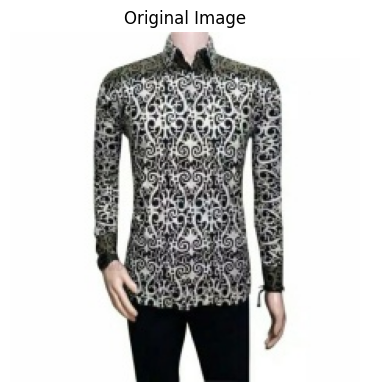

In [18]:
image_path = 'sample/image_sample.jpg'
img = image.load_img(image_path,target_size=(224,224))
plt.figure(figsize=(10,10))
plt.subplot(2, 1, 1)
plt.imshow(img)
plt.axis('off')
plt.title('Original Image')

In [19]:
def preprocessingImg(image_path):
    img = image.load_img(image_path,target_size=(224,224))
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)

    return preprocessed_img

In [26]:
def Model():
    # Load ResNet50 model without top classification layers
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    # Freeze layers in base model
    for layer in base_model.layers:
        layer.trainable = False
        
    model = tf.keras.Sequential([
        base_model,
        GlobalMaxPooling2D()
    ])
    return model
model = Model()

In [27]:
def NormalizedImage(preprocessed_img, model):
    result = model.predict(preprocessed_img).flatten()
    normalized_result = result / norm(result)
    
    return normalized_result

In [28]:
def Nearest(feature_list, NormalizedImage):
    neighbors = NearestNeighbors(n_neighbors=310,algorithm='brute',metric='euclidean')
    neighbors.fit(feature_list)
    distances,indices = neighbors.kneighbors([NormalizedImage])

    return indices

In [29]:
process_image = preprocessingImg(image_path)

In [30]:
NormalizedImage = NormalizedImage(process_image,model)

1/1 [==============================] - 10s 10s/step


In [31]:
indices_image = Nearest(feature_list, NormalizedImage)

In [ ]:
for file in indices_image[0]:
    print(filenames[file])

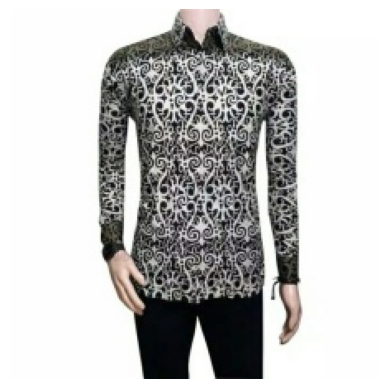

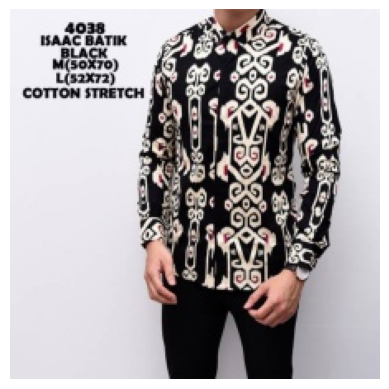

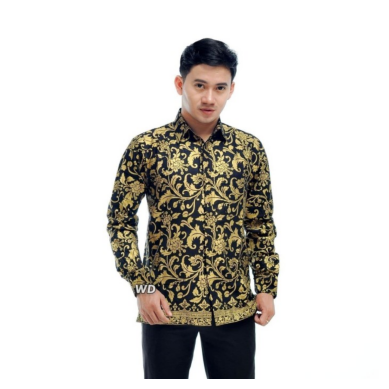

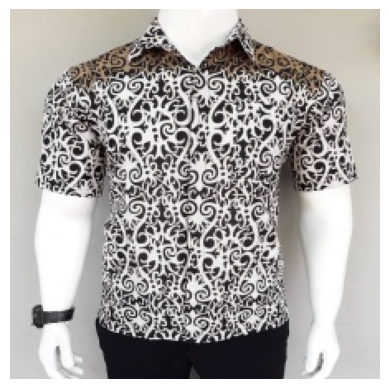

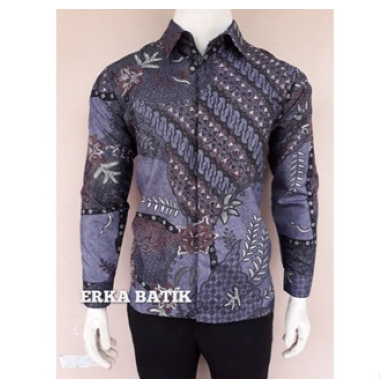

In [57]:
count = 0  # Initialize a counter
for file in indices_image[0]:
    if count >= 5:  # Limit the display to 5 images
        break

    img = cv2.imread(filenames[file], cv2.IMREAD_UNCHANGED)
    if img is not None:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()
        count += 1  # Increment counter after displaying an image
    else:
        print(f"Could not read image: {filenames[file]}")

In [58]:
import cv2
import json

# Initialize a list to store image information
image_data = []

# Assuming you have filenames and indices_image defined

count = 0  # Initialize a counter
for file in indices_image[0]:
    if count >= 5:  # Limit the collection to 5 images
        break

    img_path = filenames[file]
    img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    if img is not None:
        # Get image details (width, height, channels)
        height, width, channels = img.shape

        # Add image information to the list
        image_data.append({
            'filename': img_path,
            'width': width,
            'height': height,
            'channels': channels
        })

        count += 1  # Increment counter after processing an image
    else:
        print(f"Could not read image: {img_path}")


In [59]:
# Save the image information to a JSON file
output_filename = 'image_info.json'
with open(output_filename, 'w') as json_file:
    json.dump(image_data, json_file, indent=4)

print(f"Image information saved to {output_filename}")

Image information saved to image_info.json
